## HF Dataset

In [1]:
!pip install -U datasets fsspec


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [2]:
from datasets import load_dataset

emotion = load_dataset("emotion", cache_dir="/tmp/hf_cache")
emotion


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train = emotion["train"]

train


Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
train.column_names

['text', 'label']

In [5]:
train.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [6]:
train[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
print(train[0]["text"])
print(train[0]["label"])

i didnt feel humiliated
0


## load via url and save to disk

In [8]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

--2025-07-02 00:26:02--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train.txt.4’

train.txt.4             [ <=>                ]  70.01K  --.-KB/s    in 0.08s   

2025-07-02 00:26:02 (898 KB/s) - ‘train.txt.4’ saved [71691]



## turn to dataframe

In [9]:
import pandas as pd

emotion.set_format(type="pandas")
df = emotion["train"][:]
df.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


## turn the label (emotion) to categorical

In [10]:
def label_int2tr(label):
    return emotion["train"].features["label"].int2str(label)

df["label_str"] = df["label"].apply(label_int2tr)

df.head()

,text,label,label_str
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Class Distribution

<Axes: xlabel='label_str'>

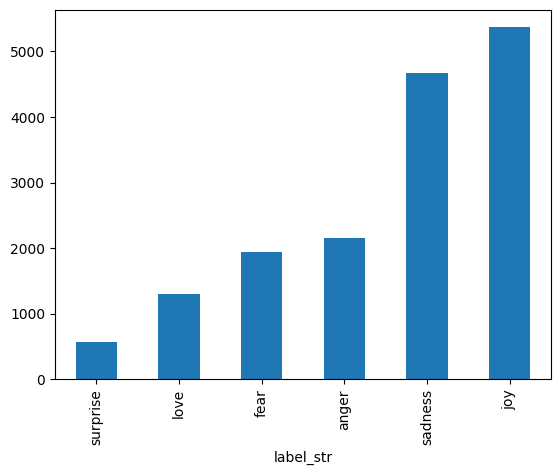

In [11]:
df["label_str"].value_counts(ascending=True).plot.bar()

# A case of imbalanced data . soultions
- Random sampling over the majority class
- random sampling under the majority class
- Gathering more data

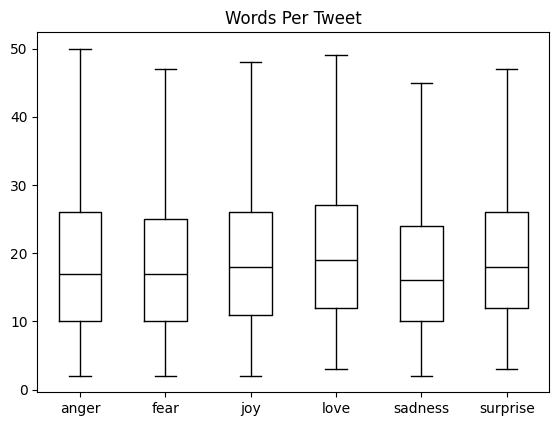

In [12]:
import matplotlib.pyplot as plt

df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_str", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## After data exploration we can turn it back to the original format

In [13]:
emotion.reset_format()

In [14]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Tokenization

In [15]:
# character tokenization
text = "Silva is an inspiring AI Engineer"

token_text = list(text)

print(token_text)  # token_text

['S', 'i', 'l', 'v', 'a', ' ', 'i', 's', ' ', 'a', 'n', ' ', 'i', 'n', 's', 'p', 'i', 'r', 'i', 'n', 'g', ' ', 'A', 'I', ' ', 'E', 'n', 'g', 'i', 'n', 'e', 'e', 'r']


In [16]:
token2int = {ch:idx for idx , ch in enumerate(sorted(set(token_text)))}
print(token2int)  # token2int

{' ': 0, 'A': 1, 'E': 2, 'I': 3, 'S': 4, 'a': 5, 'e': 6, 'g': 7, 'i': 8, 'l': 9, 'n': 10, 'p': 11, 'r': 12, 's': 13, 'v': 14}


In [17]:
input_ids = [token2int[ch] for ch in text]
print(input_ids)  # input_ids

[4, 8, 9, 14, 5, 0, 8, 13, 0, 5, 10, 0, 8, 10, 13, 11, 8, 12, 8, 10, 7, 0, 1, 3, 0, 2, 10, 7, 8, 10, 6, 6, 12]


In [18]:
# word tokenization
token_txt = text.split()
print(token_txt)  # token_txt

['Silva', 'is', 'an', 'inspiring', 'AI', 'Engineer']


In [19]:
# Subword tokenization
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenized_text = tokenizer(text)
print(tokenized_text)  # tokenized_text

{'input_ids': [101, 11183, 2003, 2019, 18988, 9932, 3992, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


# Lets tokenize the whole dataset at once

In [20]:
def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [21]:
print(tokenize_function(emotion["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [22]:
emotion_encoded = emotion.map(tokenize_function, batched=True , batch_size=None)

In [23]:
print(emotion_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Trainig a classifier

## 1- Feature Extraction

In [24]:
import torch
from transformers import AutoModel

model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)


In [25]:
def extract_hidden_states(batch):
    # Specify model input keys expected from tokenizer output
    model_input_keys = ['input_ids', 'attention_mask']  # Adjust if needed

    # Move inputs to device (e.g., GPU)
    inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() if k in model_input_keys}

    with torch.no_grad():
        outputs = model(**inputs)

    # Extract only the [CLS] token embedding (batch_size x hidden_dim)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()

    return {"hidden_states": cls_embeddings}


In [26]:
emotion_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [27]:
emotion_hidden = emotion_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

/tmp/ipython-input-25-1594233195.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() if k in model_input_keys}


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [28]:
emotion_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_states']

In [29]:
import numpy as np
X_train = np.array(emotion_hidden["train"]["hidden_states"])
X_valid = np.array(emotion_hidden["validation"]["hidden_states"])
y_train = np.array(emotion_hidden["train"]["label"])
y_valid = np.array(emotion_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [30]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

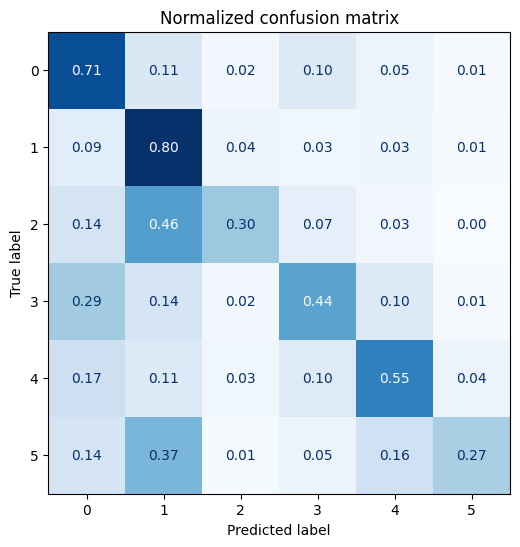

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid )

In [32]:
del model

In [33]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [38]:
from huggingface_hub import notebook_login
notebook_login()

In [40]:
from transformers import Trainer, TrainingArguments
batch_size = 64

logging_steps = len(emotion_encoded["train"]) // batch_size
model_name = f"{model_checkpoint}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


In [44]:
from transformers import Trainer

# Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded["train"],
    eval_dataset=emotion_encoded["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()


/tmp/ipython-input-44-3751585781.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: silvapi1994 (silvapi1994-karabuk-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
250,0.797900
500,0.255500


TrainOutput(global_step=500, training_loss=0.5266973342895508, metrics={'train_runtime': 291.1783, 'train_samples_per_second': 109.898, 'train_steps_per_second': 1.717, 'total_flos': 720342861696000.0, 'train_loss': 0.5266973342895508, 'epoch': 2.0})

In [45]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/silvaPI1994AI/distilbert-base-uncased-finetuned-emotion/commit/7be8dbc648d4154f4b3d15526953af452814cca6', commit_message='Training completed!', commit_description='', oid='7be8dbc648d4154f4b3d15526953af452814cca6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/silvaPI1994AI/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='silvaPI1994AI/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [46]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [47]:
custom_tweet = "All floor is heated , so be it"
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
